## NLP stuff with Spotify User Reviews

Here we load, preprocess and explore Spotify user reviews to learn NLP preprocessing methods and gain first insights into the dataset.

In [2]:
## Setting to ignore warningsc
import warnings
warnings.filterwarnings("ignore")

In [3]:
## Import general libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import emojis
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize as tokenizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [4]:
## Read data and copy
spotify = pd.read_csv("../data/raw/spotify_review_kaggle.csv")
data_in = spotify.copy()

In [5]:
## Check Data
data_in.head(10)

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN
5,2022-07-09 13:20:20,The player controls sometimes disappear for no...,3,7,NaN
6,2022-07-09 13:19:21,I love the selection and the lyrics are provid...,5,0,NaN
7,2022-07-09 13:17:22,Still extremely slow when changing storage to ...,3,16,NaN
8,2022-07-09 13:16:49,It's a great app and the best mp3 music app I ...,5,0,NaN
9,2022-07-09 13:11:32,"I'm deleting this app, for the following reaso...",1,318,NaN


In [6]:
## Sample some reviews
data_in["Review"].sample(10)

16014    There are lots of ads after every song to unsu...
22789    I love spotify !! It makes me playlist and tim...
13925    I have a xiaomi redmi note 10 pro and lyrics o...
52218    Best music streaming app. Its the one that con...
31776    Great except for the last update. Now it glitc...
30326    Rubbish, I have paid for and used this service...
36384    Terrible since latest update. As others have p...
7089     I love Spotify because it lets me be me and no...
41935    Ok, but the control panel interface randomly d...
48768    I love the whole service of the app but i want...
Name: Review, dtype: object

In [7]:
## Data info
data_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time_submitted  61594 non-null  object
 1   Review          61594 non-null  object
 2   Rating          61594 non-null  int64 
 3   Total_thumbsup  61594 non-null  int64 
 4   Reply           216 non-null    object
dtypes: int64(2), object(3)
memory usage: 2.3+ MB


In [8]:
## Remove duplicates
## Since we are changing the raw input data, let's change the name to data
print("Before dropping duplicates: ", len(data_in))
data = data_in.drop_duplicates(subset="Review")
print("After dropping duplicates: ", len(data))


Before dropping duplicates:  61594
After dropping duplicates:  61356


In [9]:
## Drop unused cols
data.drop(["Time_submitted", "Total_thumbsup", "Reply"], axis=1, inplace=True)
data.head(5)

,Review,Rating
0,"Great music service, the audio is high quality...",5
1,Please ignore previous negative rating. This a...,5
2,"This pop-up ""Get the best Spotify experience o...",4
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't ...,1


In [10]:
## Ad col for reviews length of review in words
data["Length"] = data["Review"].str.split(" ").str.len()
data.head()

,Review,Rating,Length
0,"Great music service, the audio is high quality...",5,21
1,Please ignore previous negative rating. This a...,5,15
2,"This pop-up ""Get the best Spotify experience o...",4,19
3,Really buggy and terrible to use as of recently,1,9
4,Dear Spotify why do I get songs that I didn't ...,1,21


In [11]:
## Check shortest reviews
data.sort_values("Length").head(10)

,Review,Rating,Length
24628,Easy-to-use software,5,2
30670,"Powerful,Spirit-touching songs",5,2
27164,Best music service,5,3
4562,Always interrupts ads,1,3
4569,To many advertisement!!!,1,3
9923,Too much ads.,1,3
4572,Love no ads!,5,3
33635,Brilliant music app,5,3
9938,Full of adds,1,3
13112,Great and dynamic,5,3


In [12]:
## Check longest reviews
data.sort_values("Length").tail(10)

,Review,Rating,Length
61568,I have been using Spotify premium. Biggest dis...,3,150
24495,"SPOTIFY IS TERRIBLE! Before podcasts, Spotify ...",1,157
23836,"Works fine for my phone, however for the past ...",2,159
27916,Edit - came back to remove a star. Jesus cance...,2,165
19664,Spotify is a great way to listen to music alth...,4,175
40973,Although I like Spotify and I use it a lot (an...,3,185
26055,I am giving the 3 month free trial a go and so...,4,219
46004,"I am using Spotify soon for a year, before I u...",4,222
20489,"Attention Android Users: unfortunately, there ...",1,279
40566,"I very rarely leave reviews and if I do, they'...",1,699


<Figure size 1200x600 with 0 Axes>

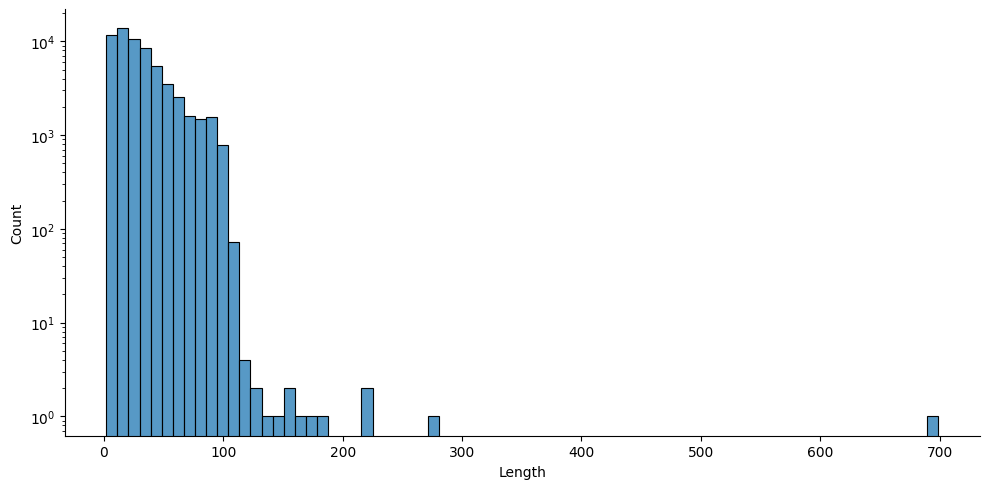

In [13]:
## Plot Review Length as hist
plt.figure(figsize=(4,2), dpi=300)
ax = sns.displot(data["Length"], kind="hist", fill=True, aspect=2, bins=75, log=True);

In [14]:
data["Length"].describe()

count    61356.000000
mean        30.991786
std         22.724590
min          2.000000
25%         14.000000
50%         25.000000
75%         42.000000
max        699.000000
Name: Length, dtype: float64

As we can see, most reviews are no longer than around 120 words; as a next step, we could remove all reviews with more than 150 words.

In [15]:
## Drop long reviews
data = data[data.Length < 150]
print("Number of reviews after trimming: ", len(data))

Number of reviews after trimming:  61346


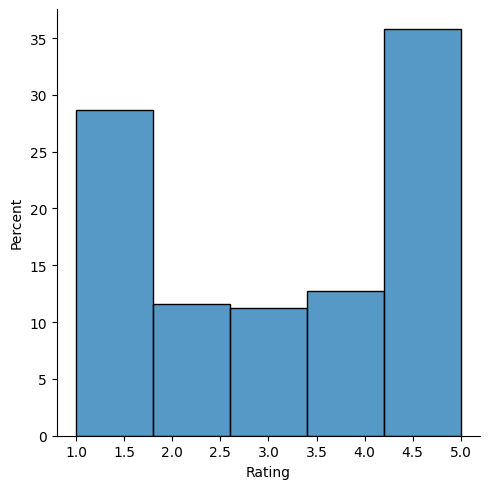

In [16]:
## Visualize distribution of ratings
ax = sns.displot(data=data, x='Rating', stat='percent', bins=5);

In [17]:
## Code sentiment from rating (1 or 2 == bad, 3 == neutral, 4 or 5 == good)
def get_sentiment(rating):
    if rating == 1 or rating == 2:
        return "negative"
    if rating == 3:
        return "neutral"
    if rating == 4 or rating == 5:
        return "positive"

In [18]:
data["Sentiment"] = data["Rating"].apply(get_sentiment)
data.head(10)

,Review,Rating,Length,Sentiment
0,"Great music service, the audio is high quality...",5,21,positive
1,Please ignore previous negative rating. This a...,5,15,positive
2,"This pop-up ""Get the best Spotify experience o...",4,19,positive
3,Really buggy and terrible to use as of recently,1,9,negative
4,Dear Spotify why do I get songs that I didn't ...,1,21,negative
5,The player controls sometimes disappear for no...,3,19,neutral
6,I love the selection and the lyrics are provid...,5,15,positive
7,Still extremely slow when changing storage to ...,3,62,neutral
8,It's a great app and the best mp3 music app I ...,5,43,positive
9,"I'm deleting this app, for the following reaso...",1,80,negative


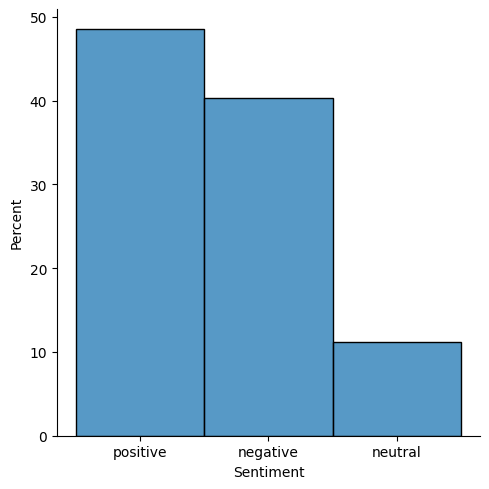

In [19]:
## Plot sentiment distribution (e.g. sns.histplot)
ax = sns.displot(data=data, x='Sentiment', stat='percent');

In [20]:
## Look for relationship between length and sentiment
data[["Length","Sentiment"]].groupby("Sentiment").describe()

Length                                                    
             count       mean        std  min   25%   50%   75%    max
Sentiment                                                             
negative   24713.0  37.777202  23.415594  3.0  20.0  32.0  50.0  137.0
neutral     6874.0  36.963777  23.270817  3.0  19.0  32.0  49.0  111.0
positive   29759.0  23.906885  19.092666  2.0  10.0  18.0  31.0  113.0

### Preprocessing

In [21]:
## Get NLTK english stopwords
our_stopwords = set(stopwords.words('english'))

In [22]:
## Run this to download all NLTK content
## WARNING: This takes a long time.
#nltk.download()

## Text Preprocessing

1. Lowercase
2. Remove Punct
3. Tokenize with standard tokenizer
4. Remove Stopwords

In [23]:
## 1. Lowercase all words
data["Review"] = data["Review"].str.lower()
data.head()

,Review,Rating,Length,Sentiment
0,"great music service, the audio is high quality...",5,21,positive
1,please ignore previous negative rating. this a...,5,15,positive
2,"this pop-up ""get the best spotify experience o...",4,19,positive
3,really buggy and terrible to use as of recently,1,9,negative
4,dear spotify why do i get songs that i didn't ...,1,21,negative


In [24]:
data["Review"].sample(20)

15070    spotify is a great app,i think we all sgoyld h...
52751                 love, love, love spotify. great app.
61054    i have got premium subscription but the playli...
16454    great music or podcast streaming app. would re...
27129    i can reply the same song i want to play and i...
10108            great but wish they would mix it up more.
30013    will just turn itself on whenever bluetooth is...
2646     love love love it, always clear music and the ...
28217    spotify won't let me log in on my facebook acc...
5428     i love how this works. it's smooth and i know ...
41443    too many ads,other than that spotify is defini...
20635    used to be amazing now a lot of bugs plays sam...
60499    never any problems..always really good songs v...
49647    i hate this app. right in the middle of a podc...
32049    buggy updates recent update causes music stop ...
20710    updated app 05/18/2022 and the player and cont...
5558     don't download guys , this is not music app , .

In [25]:
## 2./3. Tokenize/Remove Punctuation
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [26]:
tokens = data["Review"].apply(tokenizer.tokenize)

In [27]:
tokens.sample(20)

36302    [constantly, pausing, or, just, outright, clos...
47806    [alexa, friendly, allows, music, to, be, heard...
38450    [i, enjoy, the, ease, of, listening, to, my, f...
15502    [this, plays, songs, that, i, haven, t, heard,...
49100    [please, add, forward, and, previous, song, bu...
29854    [creating, account, is, so, annoying, errors, ...
9030     [the, app, was, good, for, the, past, 4, days,...
8642     [i, have, to, keep, re, downloading, the, app,...
5090             [7, ads, in, one, go, that, s, too, much]
41658    [i, love, this, app, because, i, listen, to, a...
11096    [i, love, this, app, would, recommend, it, to,...
36502    [i, love, this, app, bt, i, have, face, a, pro...
32200    [exceptional, i, love, how, it, recommends, mu...
7882     [add, some, more, advertisements, so, we, can,...
40903    [good, just, can, t, figure, out, how, to, sav...
17501    [don, t, install, this, app, advertising, is, ...
43122    [rating, 1, star, until, the, app, works, with.

In [28]:
## Join tokens to our dataframe
data["Tokens"] = tokens

In [29]:
data.head()

,Review,Rating,Length,Sentiment,Tokens
0,"great music service, the audio is high quality...",5,21,positive,"[great, music, service, the, audio, is, high, ..."
1,please ignore previous negative rating. this a...,5,15,positive,"[please, ignore, previous, negative, rating, t..."
2,"this pop-up ""get the best spotify experience o...",4,19,positive,"[this, pop, up, get, the, best, spotify, exper..."
3,really buggy and terrible to use as of recently,1,9,negative,"[really, buggy, and, terrible, to, use, as, of..."
4,dear spotify why do i get songs that i didn't ...,1,21,negative,"[dear, spotify, why, do, i, get, songs, that, ..."


In [30]:
## 4. Remove Stopwords
## Here we loop through each list of words and remove stopwords
data['Tokens_no_stopwords'] = data['Tokens'].apply(lambda x: [word for word in x if word not in (our_stopwords)])
data.head()

,Review,Rating,Length,Sentiment,Tokens,Tokens_no_stopwords
0,"great music service, the audio is high quality...",5,21,positive,"[great, music, service, the, audio, is, high, ...","[great, music, service, audio, high, quality, ..."
1,please ignore previous negative rating. this a...,5,15,positive,"[please, ignore, previous, negative, rating, t...","[please, ignore, previous, negative, rating, a..."
2,"this pop-up ""get the best spotify experience o...",4,19,positive,"[this, pop, up, get, the, best, spotify, exper...","[pop, get, best, spotify, experience, android,..."
3,really buggy and terrible to use as of recently,1,9,negative,"[really, buggy, and, terrible, to, use, as, of...","[really, buggy, terrible, use, recently]"
4,dear spotify why do i get songs that i didn't ...,1,21,negative,"[dear, spotify, why, do, i, get, songs, that, ...","[dear, spotify, get, songs, put, playlist, shu..."


## TEXT TRANSFORMATIONS
5. Bag of Word Model/Count Vectorize
6. Term-Frequency Inverse-Document-Frequency (TF-IDF)/ TFIDF Vectorizer
7. Delete highly frequent and very low frequent tokens
8. Select top _n_ tokens

Until now, the text was still in text form; all we did was cleaning words and characters that won't give us a lot of signal. The next step, however, is to _transform_ the text into numeric representations, aka something a computer can understand. This involves fitting a transformer to data. In order to prevent __data spillage__, it is important to split our data into a training, development, and test set. Any transformer should only be fit to the training data set.

In [31]:
X = data["Tokens_no_stopwords"]
y = data["Sentiment"]
print("Shape of X and y: ", X.shape, y.shape)

Shape of X and y:  (61346,) (61346,)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify = y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(36807,) (24539,) (36807,) (24539,)


In [33]:
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify = y_test, random_state=42)
print(X_dev.shape, X_test.shape, y_dev.shape, y_test.shape)

(12269,) (12270,) (12269,) (12270,)


In [34]:
print(y_train.unique(), y_test.unique(), y_dev.unique())

['positive' 'negative' 'neutral'] ['neutral' 'negative' 'positive'] ['neutral' 'negative' 'positive']


In [35]:
## Encode labels in sklearn style
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_dev = label_encoder.transform(y_dev)
y_test = label_encoder.transform(y_test)

In [36]:
## TRANSFORMATIONS
## 5. Counts
from sklearn.feature_extraction.text import CountVectorizer

In [37]:
## hacky solution, meh
def dummy(doc):
    return doc
count_vectorizer = CountVectorizer(tokenizer=dummy, preprocessor=dummy)
## Only fit on training set
count_vectorizer.fit(X_train)
X_train_counts = count_vectorizer.transform(X_train)
X_dev_counts = count_vectorizer.transform(X_dev)


In [38]:
## We can get the vocabulary (= all our tokens) from the vectorizer as a dict
vocabulary = count_vectorizer.vocabulary_
list(vocabulary.keys())[:10] # Show ten

['loving',
 'app',
 'lots',
 'music',
 'choose',
 'podcasts',
 'turn',
 'bluetooth',
 'notification',
 'every']

In [39]:
## Let's have a look at tokens and their ID, sorted alphabetically
pd.DataFrame(vocabulary.items()).rename(columns={0: "token", 1: "ID"}).sort_values("ID", ascending=True).head(10)

,token,ID
331,0,0
3446,00,1
3301,000,2
4961,000000001,3
14200,001,4
14752,003,5
9606,00348,6
14753,005,7
106,00s,8
4007,01,9


In [40]:
## Same for the tail
pd.DataFrame(vocabulary.items()).rename(columns={0: "token", 1: "ID"}).sort_values("ID", ascending=True).tail(10)

,token,ID
8714,𝚑𝚊𝚟𝚎,18297
8713,𝚒,18298
5355,𝚒𝚜,18299
8716,𝚕𝚘𝚟𝚎𝚍,18300
5357,𝚖𝚘𝚜𝚝,18301
5359,𝚖𝚞𝚜𝚒𝚌,18302
5356,𝚝𝚑𝚎,18303
5353,𝚝𝚑𝚒𝚗𝚔,18304
5354,𝚝𝚑𝚒𝚜,18305
4482,𝟐𝐱,18306


We see that we have a lot of digits and strange font words that we might want to take care of later. Also, our dictionary contains __18 306 tokens__.

In [1]:
## TRANSFORMATIONS
## 6. TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer

In [42]:
## hacky solution
def dummy(doc):
    return doc
tfidf_vectorizer = TfidfVectorizer(tokenizer=dummy, preprocessor=dummy)
## Only fit on training set
tfidf_vectorizer.fit(X_train)
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_dev_tfidf = tfidf_vectorizer.transform(X_dev)

# Pipeline

In [56]:
check = ["our review"]
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(check)

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

log_model = LogisticRegression()

pipeline = make_pipeline(tfidf_vectorizer, log_model)



In [57]:
pipeline.fit(X_train, y_train)

AttributeError: 'list' object has no attribute 'lower'

In [46]:
import pickle

pickle.dump(pipeline, open('..\models\our_pipeline.pickle', 'wb'))

In [43]:
print("Vocabulary size: ", len(tfidf_vectorizer.vocabulary_))

Vocabulary size:  18307


## Classification of sentiment

In [44]:
## Import some classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier # never used that one before

### Use Bag of Words/Count vectorized features for classification

In [409]:
## Initlilize classifiers with default hyperparams
log1 = LogisticRegression()
rf1 = RandomForestClassifier()
svc1 = SVC()
nb1 = MultinomialNB()
gbm1 = LGBMClassifier(objective='multiclass')

X_train_counts = X_train_counts.astype('float32')
X_dev_counts = X_dev_counts.astype('float32')   
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


classifiers = [log1, rf1, svc1, nb1, gbm1]

for classifier in classifiers:
    print(f"Fitting {classifier}...")
    classifier.fit(X_train_counts, y_train)
    print(f"{classifier} accuracy on Count Vector: {classifier.score(X_dev_counts, y_dev)}")


Fitting LogisticRegression()...
LogisticRegression() accuracy on Count Vector: 0.7697448854837395
Fitting RandomForestClassifier()...
RandomForestClassifier() accuracy on Count Vector: 0.7714565164235064
Fitting SVC()...
SVC() accuracy on Count Vector: 0.7818893145325617
Fitting MultinomialNB()...
MultinomialNB() accuracy on Count Vector: 0.7719455538348684
Fitting LGBMClassifier(objective='multiclass')...
LGBMClassifier(objective='multiclass') accuracy on Count Vector: 0.779281115005298


### TFIDF Vectorized features for classification

In [410]:
## Initlilize classifiers with default hyperparams
log2 = LogisticRegression()
rf2 = RandomForestClassifier()
svc2 = SVC()
nb2 = MultinomialNB()
gbm2 = LGBMClassifier(objective='multiclass')

X_train_tfidf = X_train_tfidf.astype('float32')
X_dev_tfidf = X_dev_tfidf.astype('float32')   
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


classifiers = [log2, rf2, svc2, nb2, gbm2]

for classifier in classifiers:
    print(f"Fitting {classifier}...")
    classifier.fit(X_train_tfidf, y_train)
    print(f"{classifier} accuracy on TF-IDF Vector: {classifier.score(X_dev_tfidf, y_dev)}")


Fitting LogisticRegression()...
LogisticRegression() accuracy on TF-IDF Vector: 0.7858016138234575
Fitting RandomForestClassifier()...
RandomForestClassifier() accuracy on TF-IDF Vector: 0.7675442171326107
Fitting SVC()...
SVC() accuracy on TF-IDF Vector: 0.7891433694677643
Fitting MultinomialNB()...
MultinomialNB() accuracy on TF-IDF Vector: 0.7747982720678132
Fitting LGBMClassifier(objective='multiclass')...
LGBMClassifier(objective='multiclass') accuracy on TF-IDF Vector: 0.7760208655962181


### Reduce dimensionality by trimming high/low frequent tokens

In [157]:
## hacky solution
def dummy(doc):
    return doc
tfidf_vectorizer_trimmer = TfidfVectorizer(tokenizer=dummy, preprocessor=dummy, max_df=.90, min_df=0.0001, )
## Only fit on training set
tfidf_vectorizer_trimmer.fit(X_train)
X_train_tfidf_trimmed = tfidf_vectorizer_trimmer.transform(X_train)
X_dev_tfidf_trimmed = tfidf_vectorizer_trimmer.transform(X_dev)

In [158]:
print("Vocabulary size: ", len(tfidf_vectorizer_trimmer.vocabulary_))

Vocabulary size:  18307


In [133]:
## Initlilize classifiers with default hyperparams
log3 = LogisticRegression()
rf3 = RandomForestClassifier()
svc3 = SVC()
nb3 = MultinomialNB()
gbm3 = LGBMClassifier(objective='multiclass')

X_train_tfidf_trimmed = X_train_tfidf_trimmed.astype('float32')
X_dev_tfidf_trimmed = X_dev_tfidf_trimmed.astype('float32')   
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


classifiers = [log3, rf3, svc3, nb3, gbm3]

for classifier in classifiers:
    print(f"Fitting {classifier}...")
    classifier.fit(X_train_tfidf_trimmed, y_train)
    print(f"{classifier} accuracy on trimmed TF-IDF Vector: {classifier.score(X_dev_tfidf_trimmed, y_dev)}")


Fitting LogisticRegression()...
LogisticRegression() accuracy on trimmed TF-IDF Vector: 0.7863721574700464
Fitting RandomForestClassifier()...
RandomForestClassifier() accuracy on trimmed TF-IDF Vector: 0.7650175238405738
Fitting SVC()...
SVC() accuracy on trimmed TF-IDF Vector: 0.7890618632325372
Fitting MultinomialNB()...
MultinomialNB() accuracy on trimmed TF-IDF Vector: 0.7722715787757763
Fitting LGBMClassifier(objective='multiclass')...
LGBMClassifier(objective='multiclass') accuracy on trimmed TF-IDF Vector: 0.7768359279484881


### Reduce dimensionality by selecting top _n_ tokens

In [155]:
## hacky solution
def dummy(doc):
    return doc
tfidf_vectorizer_top = TfidfVectorizer(tokenizer=dummy, preprocessor=dummy, max_features=10000, ngram_range=(1,3))
## Only fit on training set
tfidf_vectorizer_top.fit(X_train)
X_train_tfidf_top = tfidf_vectorizer_top.transform(X_train)
X_dev_tfidf_top = tfidf_vectorizer_top.transform(X_dev)

In [156]:
print("Vocabulary size: ", len(tfidf_vectorizer_top.vocabulary_))

Vocabulary size:  10000


In [138]:
## Initlilize classifiers with default hyperparams
log4 = LogisticRegression()
rf4 = RandomForestClassifier()
svc4 = SVC()
nb4 = MultinomialNB()
gbm4 = LGBMClassifier(objective='multiclass')

X_train_tfidf_top = X_train_tfidf_top.astype('float32')
X_dev_tfidf_top = X_dev_tfidf_top.astype('float32')   
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


classifiers = [log4, rf4, svc4, nb4, gbm4]

for classifier in classifiers:
    print(f"Fitting {classifier}...")
    classifier.fit(X_train_tfidf_top, y_train)
    print(f"{classifier} accuracy on top-n TF-IDF Vector: {classifier.score(X_dev_tfidf_top, y_dev)}")


Fitting LogisticRegression()...
LogisticRegression() accuracy on top-n TF-IDF Vector: 0.7866166761757274
Fitting RandomForestClassifier()...
RandomForestClassifier() accuracy on top-n TF-IDF Vector: 0.7678702420735186
Fitting SVC()...
SVC() accuracy on top-n TF-IDF Vector: 0.7893878881734453
Fitting MultinomialNB()...
MultinomialNB() accuracy on top-n TF-IDF Vector: 0.7739832097155432
Fitting LGBMClassifier(objective='multiclass')...
LGBMClassifier(objective='multiclass') accuracy on top-n TF-IDF Vector: 0.777161952889396


### Use bigrams and trigrams in addition to single word tokens


In [56]:
## hacky solution
def dummy(doc):
    return doc
tfidf_vectorizer_ngram = TfidfVectorizer(tokenizer=dummy, preprocessor=dummy, max_features=10000, ngram_range=(1,3))
## Only fit on training set
tfidf_vectorizer_ngram.fit(X_train)
X_train_tfidf_ngram = tfidf_vectorizer_ngram.transform(X_train)
X_dev_tfidf_ngram = tfidf_vectorizer_ngram.transform(X_dev)

In [57]:
## Initlilize classifiers with default hyperparams
log5 = LogisticRegression()
rf5 = RandomForestClassifier()
svc5 = SVC()
nb5 = MultinomialNB()
gbm5 = LGBMClassifier(objective='multiclass')

X_train_tfidf_ngram = X_train_tfidf_ngram.astype('float32')
X_dev_tfidf_ngram = X_dev_tfidf_ngram.astype('float32')   
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


classifiers = [log5, rf5, svc5, nb5, gbm5]

for classifier in classifiers:
    print(f"Fitting {classifier}...")
    classifier.fit(X_train_tfidf_ngram, y_train)
    print(f"{classifier} accuracy on top-n TF-IDF Vector: {classifier.score(X_dev_tfidf_ngram, y_dev)}")


Fitting LogisticRegression()...
LogisticRegression() accuracy on top-n TF-IDF Vector: 0.7902029505257152
Fitting RandomForestClassifier()...
RandomForestClassifier() accuracy on top-n TF-IDF Vector: 0.7701524166598744
Fitting SVC()...
SVC() accuracy on top-n TF-IDF Vector: 0.7901214442904883
Fitting MultinomialNB()...
MultinomialNB() accuracy on top-n TF-IDF Vector: 0.778547558888255
Fitting LGBMClassifier(objective='multiclass')...
LGBMClassifier(objective='multiclass') accuracy on top-n TF-IDF Vector: 0.7796886461814329
